In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path    
import seaborn as sns
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "results/FD_runs"

In [3]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [4]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [5]:
def model(x,a,b,c):
    return a*x**b+c

In [6]:
jobids = []
params = []
data = []
N = 18
folders = [datapath/"h=0",datapath/"h=2",datapath/"h=12"]
files = ["5213192_N18_FD.jld2","5213196-5213215_N18_FD.jld2","5213216-5213235_N18_FD.jld2"]
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        if i == 0:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data.append(2-2*rearrange_data(f["data"][()]))
        else:
            jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
            data.append(2-2*np.array([rearrange_data(f[f["data"][l]]) for l in range(len(f["data"]))]))
        params.append(f["params"][()])
for  i in range(1,3):
    data[i] = np.concatenate(data[i],axis=2)
T = np.arange(0,5.1,0.1)
xcenter = N//2

In [7]:
data[1].shape

(51, 18, 100)

In [8]:
def symmetrize(arr): #Only use if N odd
    c = arr.shape[1]//2
    new_arr = np.zeros((arr.shape[0],arr.shape[1]))
    for i in range(0,arr.shape[1]//2):
        new_arr[:,i] = (arr[:,c-i]+arr[:,c+i])/2
    for i in range(arr.shape[1]//2,arr.shape[1]):
        new_arr[:,i] = new_arr[:,c-(i-c)]
    new_arr = np.roll(new_arr,arr.shape[1]//2,axis=1)
    return new_arr

In [9]:
#res = list(map(lambda arr: symmetrize(disorder_mean(arr)),data))
#res_err = list(map(lambda arr: symmetrize(disorder_std(arr)),data))
res = list(map(lambda arr: disorder_mean(arr),data))
res_err = list(map(lambda arr: disorder_std(arr),data))

In [10]:
xvals = np.array([abs(pos-xcenter) for pos in range(1,N+1)])

# h = 0

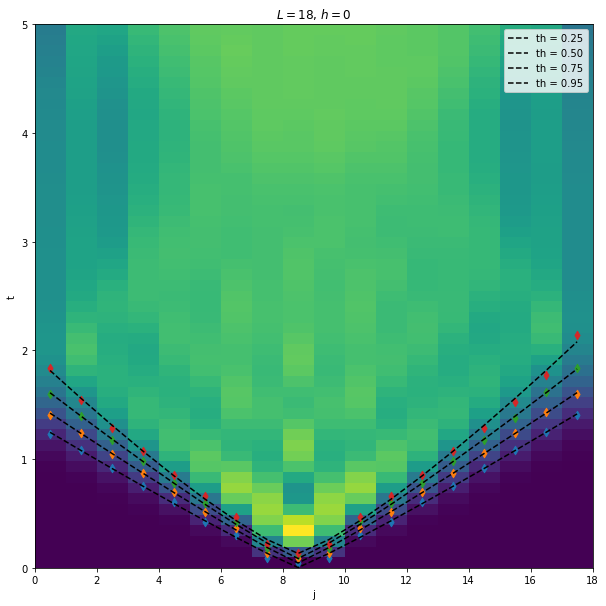

In [28]:
thresholds = [0.25,0.5,0.75,0.95]#,1.0]#,1.25]#,1.5,1.75,2]
fit_params = []
fit_errs = []
tvals = []
for (i,th) in enumerate(thresholds):
    tvals.append(T_transgression(T,res[0],th))
    popt, pcov = curve_fit(model,xvals,tvals[i])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))
plt.figure(figsize=(10,10))
linestyles = ["-","--","-."]
plt.imshow(res[0],cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    plt.plot(np.arange(0,N,1)+0.5,model(xvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
    plt.scatter(np.arange(0,N,1)+0.5,tvals[i], marker= "d")
plt.clim(0,2)
plt.xlabel("j")
plt.ylabel("t")
#plt.colorbar()
plt.legend()
plt.title(r"$L=18$, $h=0$")
plt.show()

In [29]:
print("a*x^b+c\n")
for i in range(0,4):
    print("th = {:.2f}: a = {:f}+/-{:f}, b = {:f}+/-{:f}, c = {:f}+/-{:f}\n".format(thresholds[i],fit_params[i][0],fit_errs[i][0],fit_params[i][1],fit_errs[i][1],fit_params[i][2],fit_errs[i][2]))

a*x^b+c

th = 0.25: a = 0.130851+/-0.011660, b = 1.082809+/-0.038109, c = 0.002584+/-0.018469

th = 0.50: a = 0.142540+/-0.011877, b = 1.091114+/-0.035683, c = 0.044088+/-0.018973

th = 0.75: a = 0.142426+/-0.010728, b = 1.139923+/-0.032489, c = 0.085551+/-0.018027

th = 0.95: a = 0.128242+/-0.012698, b = 1.238050+/-0.043249, c = 0.131799+/-0.023742



In [31]:
((2-fit_params[1][2])/fit_params[1][0])**(1/fit_params[1][1])

11.026336397382126

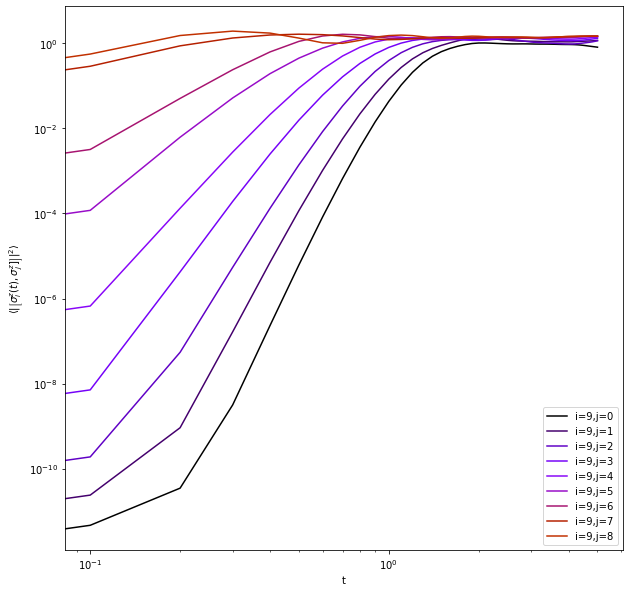

In [26]:
NUM_COLORS = N//2
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for j in range(0,N//2):
    ax.loglog(T,res[0][:,j],label="i=9,j={}".format(j))
ax.legend(loc="lower right")
ax.set_xlabel("t")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
#ax.set_ylim(1e-12,5)
plt.show()

# h = 2

/tmp/ipykernel_26353/3000542179.py:2: RuntimeWarning: divide by zero encountered in power
  return a*x**b+c


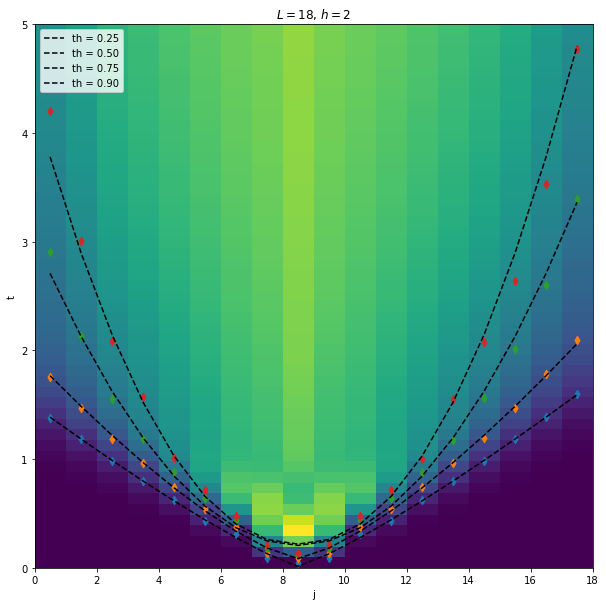

In [13]:
thresholds = [0.25,0.5,0.75,0.9]#,1.25,1.5,1.75,2]
fit_params = []
fit_errs = []
tvals = []
for (i,th) in enumerate(thresholds):
    tvals.append(T_transgression(T,res[1],th))
    popt, pcov = curve_fit(model,xvals,tvals[i])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))
plt.figure(figsize=(10,10))
linestyles = ["-","--","-."]
plt.imshow(res[1],cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    plt.plot(np.arange(0,N,1)+0.5,model(xvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
    plt.scatter(np.arange(0,N,1)+0.5,tvals[i], marker= "d")
plt.clim(0,2)
#plt.colorbar()
plt.xlabel("j")
plt.ylabel("t")
plt.legend()
plt.title(r"$L=18$, $h=2$")
plt.show()

In [14]:
res[0][0:11,9]

array([-2.22044605e-15,  2.88498501e-01,  8.71261520e-01,  1.33240852e+00,
        1.56857291e+00,  1.64085634e+00,  1.60222407e+00,  1.49637384e+00,
        1.36666443e+00,  1.26100498e+00,  1.21715533e+00])

In [15]:
print("a*x^b+c\n")
for i in range(0,4):
    print("th = {:.2f}: a = {:f}+/-{:f}, b = {:f}+/-{:f}, c = {:f}+/-{:f}\n".format(thresholds[i],fit_params[i][0],fit_errs[i][0],fit_params[i][1],fit_errs[i][1],fit_params[i][2],fit_errs[i][2]))

a*x^b+c

th = 0.25: a = 0.115896+/-0.008873, b = 1.188642+/-0.033238, c = 0.013265+/-0.015708

th = 0.50: a = 0.097327+/-0.009032, b = 1.370443+/-0.041089, c = 0.084614+/-0.019698

th = 0.75: a = 0.041351+/-0.009359, b = 1.973030+/-0.103538, c = 0.205764+/-0.046038

th = 0.90: a = 0.041854+/-0.012377, b = 2.137028+/-0.135842, c = 0.218270+/-0.077861



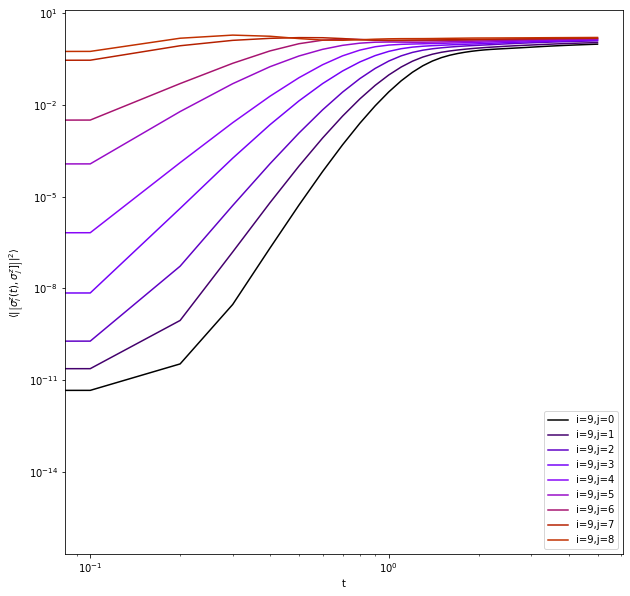

In [27]:
NUM_COLORS = N//2
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for j in range(0,N//2):
    ax.loglog(T,res[1][:,j],label="i=9,j={}".format(j))
ax.legend(loc="lower right")
ax.set_xlabel("t")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
#ax.set_ylim(1e-12,5)
plt.show()

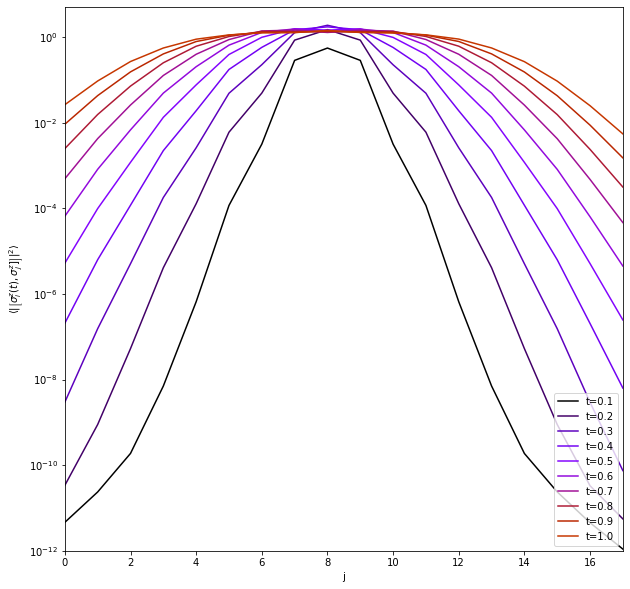

In [17]:
NUM_COLORS = 10
cm = plt.get_cmap('gnuplot')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS+5)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for t in range(1,11,1):
    ax.semilogy(range(0,N),res[1][t,:],label="t={:.1f}".format(t*0.1))
ax.legend(loc="lower right")
ax.set_xlabel("j")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
ax.set_ylim(1e-12,5)
ax.set_xlim(0,17)
plt.show()

# h = 12

/tmp/ipykernel_40277/3000542179.py:2: RuntimeWarning: divide by zero encountered in power
  return a*x**b+c


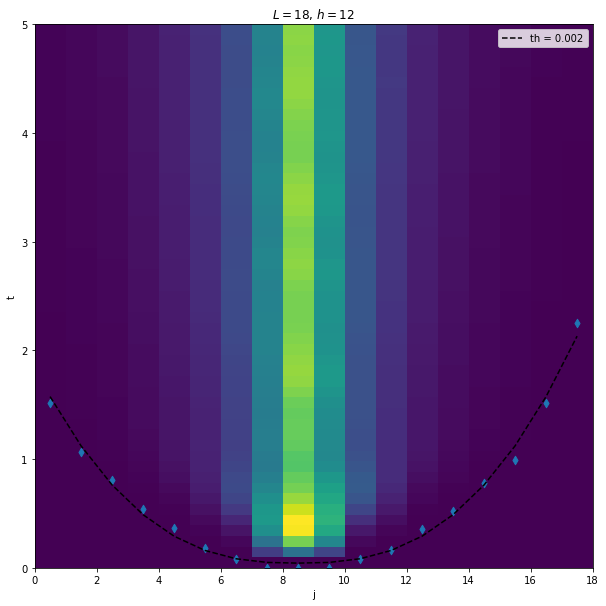

In [18]:
thresholds = [0.002]#,0.5,0.75,1.0]#,1.25,1.5,1.75,2]
fit_params = []
fit_errs = []
tvals = []
for (i,th) in enumerate(thresholds):
    tvals.append(T_transgression(T,res[2],th))
    popt, pcov = curve_fit(model,xvals,tvals[i])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))
plt.figure(figsize=(10,10))
linestyles = ["-","--","-."]
plt.imshow(res[2],cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    plt.plot(np.arange(0,N,1)+0.5,model(xvals,*fit_params[i]),label="th = {:.3f}".format(th),color="black",ls="--")
    plt.scatter(np.arange(0,N,1)+0.5,tvals[i], marker= "d")
plt.clim(0,2)
plt.xlabel("j")
plt.ylabel("t")
#plt.colorbar()
plt.legend()
plt.title(r"$L=18$, $h=12$")
plt.show()

In [19]:
print("a*x^b+c\n")
for i in range(0,1):
    print("th = {:.2f}: a = {:f}+/-{:f}, b = {:f}+/-{:f}, c = {:f}+/-{:f}\n".format(thresholds[i],fit_params[i][0],fit_errs[i][0],fit_params[i][1],fit_errs[i][1],fit_params[i][2],fit_errs[i][2]))

a*x^b+c

th = 0.00: a = 0.006477+/-0.002138, b = 2.628526+/-0.152663, c = 0.042995+/-0.029392



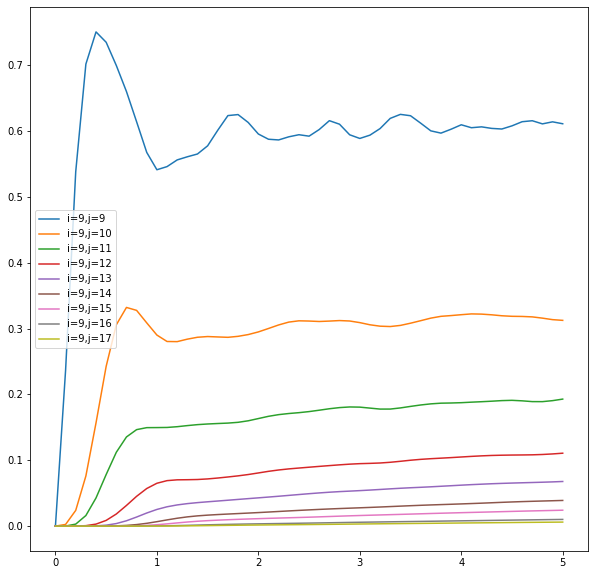

In [20]:
plt.figure(figsize=(10,10))
for j in range(9,N):
    plt.plot(T,res[2][:,j],label="i=9,j={}".format(j))
plt.legend()
plt.show()